# Baseline

## Imports

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score 
from sklearn.utils import resample

## Load the data

In [2]:
X = pd.read_csv('data/cs-training.csv')
print "Original data shape", X.shape

Original data shape (150000, 12)


In [3]:
# select the target variable
y = X['SeriousDlqin2yrs']
X = X.drop(['SeriousDlqin2yrs'], axis = 1)

In [4]:
# drop index 
X = X.loc[:, ~X.columns.str.contains('^Unnamed')]

In [5]:
print "Initial X and y shapes", X.shape, y.shape

Initial X and y shapes (150000, 10) (150000,)


In [6]:
sum(y==1)/float(len(y))

0.06684

Relative percentage of the two classes (initial dataset) = 0.06684 


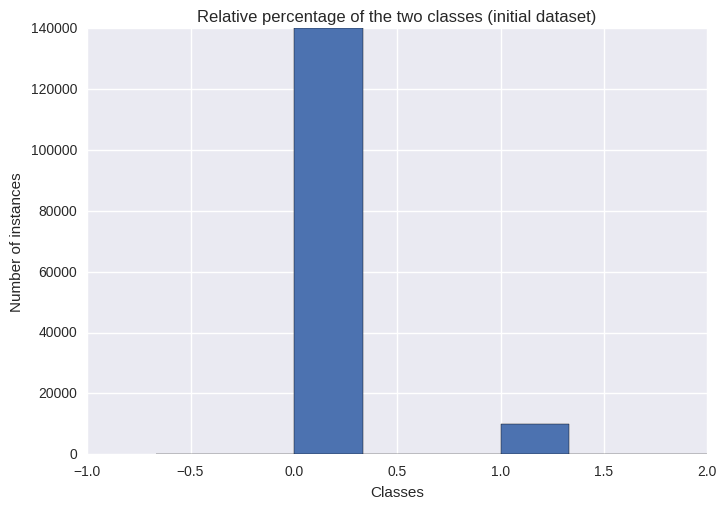

In [7]:
print 'Relative percentage of the two classes (initial dataset) = %.5f ' % (sum(y==1)/float(len(y)))
plt.title('Relative percentage of the two classes (initial dataset)')
plt.ylabel('Number of instances')
plt.xlabel('Classes')
bins = np.linspace(-1, 2, 10)
plt.hist(y, bins)
plt.show()

## Preparing the dataset

In [8]:
# imputing the dataset
im = Imputer(strategy='median')
X = im.fit_transform(X)

In [9]:
# randomizing the dataset
X, y = shuffle(X, y, random_state=0)

In [10]:
# scaling the dataset
X = np.asarray(scale(X))

In [11]:
# adding polynomial features
poly = PolynomialFeatures(2, interaction_only=True)
X = poly.fit_transform(X)

In [12]:
print "Check of the dataset shapes", X.shape, y.shape

Check of the dataset shapes (150000, 56) (150000,)


In [13]:
X = np.asarray(X)
y = np.asarray(y)

## Splitting the dataset

In [14]:
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train_test, X_val = X[train_index], X[test_index]
    y_train_test, y_val = y[train_index], y[test_index]

In [15]:
for train_index, test_index in sss.split(X_train_test, y_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]

In [16]:
print "Checking the data shapes :"
print "Training data shape : ", X_train.shape, y_train.shape
print "Validation data shape : ", X_val.shape, y_val.shape 
print "Test data shape : ", X_test.shape, y_test.shape 
print "No observations lost? : ", y_test.shape[0] + y_val.shape[0] + y_train.shape[0] == y.shape[0]

Checking the data shapes :
Training data shape :  (121500, 56) (121500,)
Validation data shape :  (15000, 56) (15000,)
Test data shape :  (13500, 56) (13500,)
No observations lost? :  True


Relative percentage of the two classes (training dataset) = 0.06684 


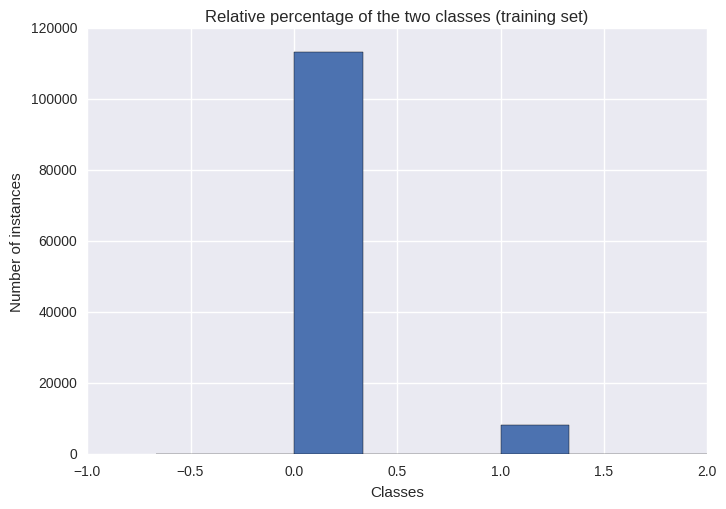

In [17]:
print 'Relative percentage of the two classes (training dataset) = %.5f ' % (sum(y_train==1)/float(len(y_train)))
plt.title('Relative percentage of the two classes (training set)')
plt.ylabel('Number of instances')
plt.xlabel('Classes')
bins = np.linspace(-1, 2, 10)
plt.hist(y_train, bins)
plt.show()

Relative percentage of the two classes (validation dataset) = 0.06687 


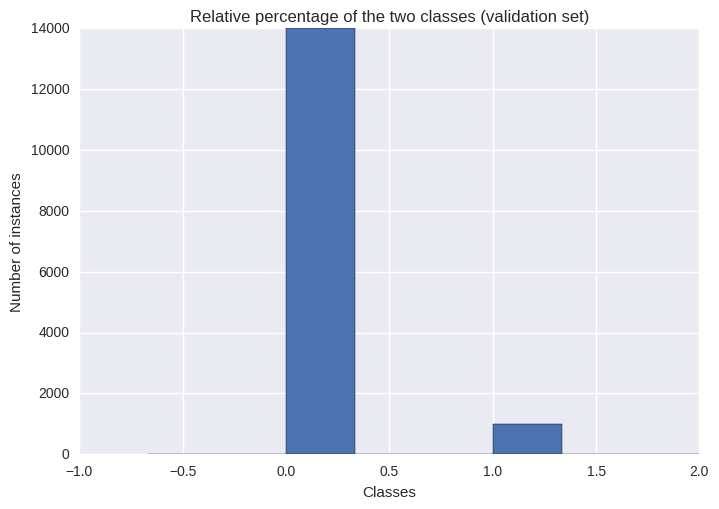

In [18]:
print 'Relative percentage of the two classes (validation dataset) = %.5f ' % (sum(y_val==1)/float(len(y_val)))
plt.title('Relative percentage of the two classes (validation set)')
plt.ylabel('Number of instances')
plt.xlabel('Classes')
bins = np.linspace(-1, 2, 10)
plt.hist(y_val, bins)
plt.show()

Relative percentage of the two classes (test dataset) = 0.06681 


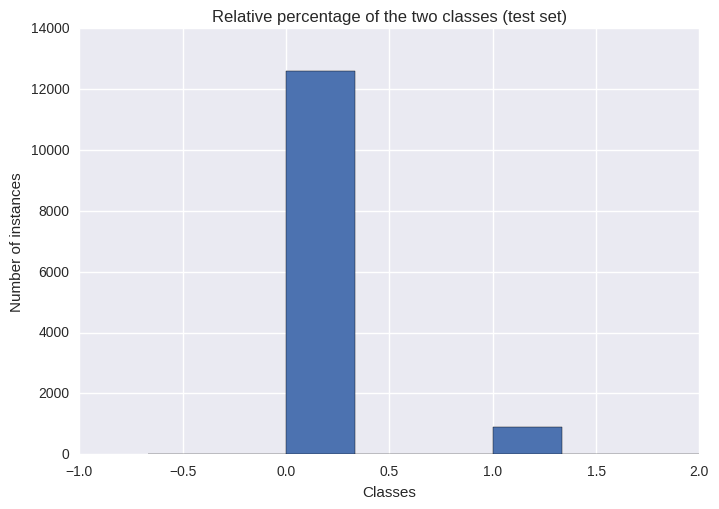

In [19]:
print 'Relative percentage of the two classes (test dataset) = %.5f ' % (sum(y_test==1)/float(len(y_test)))
plt.title('Relative percentage of the two classes (test set)')
plt.ylabel('Number of instances')
plt.xlabel('Classes')
bins = np.linspace(-1, 2, 10)
plt.hist(y_test, bins)
plt.show()

## Save the datasets

In [20]:
np.savetxt('./data/data_matrices/credit_train.data' , X_train) 
np.savetxt('./data/data_matrices/credit_train.solution' , y_train)

np.savetxt('./data/data_matrices/credit_valid.data' , X_val)
np.savetxt('./data/data_matrices/credit_valid.solution' , y_val)

np.savetxt('./data/data_matrices/credit_test.data' , X_test)
np.savetxt('./data/data_matrices/credit_test.solution' , y_test)

## Basline model

In [21]:
Xy = np.hstack((X_train,y_train.reshape(-1,1)))

In [22]:
# Separate majority and minority classes
majority = Xy[Xy[:,Xy.shape[1]-1]==0]
minority = Xy[Xy[:,Xy.shape[1]-1]==1]
 
# Upsample minority class
minority_upsampled = resample(minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(Xy[Xy[:,Xy.shape[1]-1]==0]),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
upsampled = np.vstack([majority, minority_upsampled])

In [23]:
X_train = upsampled[:,:-1]
y_train = upsampled[:,-1]

In [25]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)
print "AUC score on the validation set = %.5f " % roc_auc_score(y_val , clf.predict(X_val))
print "AUC score on the test set = %.5f " % roc_auc_score(y_test , clf.predict(X_test))

AUC score on the validation set = 0.75225 
AUC score on the test set = 0.73294 


<b>Attention : </b> Please note that on the leaderboard, we reach more than 0.8 as of the AUC score. We suspect the data in both the private and public leaderborad hasn't the same percentage of postive and negative examples. In this case, if we note that if we always predict 0, we can get a peformance of 1-0.06681 = 0.93319. That's why I believe we need, to use a balanced dataset in the validation and test sets. 

## Final safety check

In [26]:
X_train = np.loadtxt('./data/data_matrices/credit_train.data', delimiter = ' ')
y_train = np.loadtxt('./data/data_matrices/credit_train.solution')
y_val = np.loadtxt('./data/data_matrices/credit_valid.solution')
y_test = np.loadtxt('./data/data_matrices/credit_test.solution')
X_val = np.loadtxt('./data/data_matrices/credit_valid.data', delimiter = ' ')
X_test = np.loadtxt('./data/data_matrices/credit_test.data', delimiter = ' ')

In [27]:
print "Final checking of the data shapes :"
print "Training data shape : ", X_train.shape, y_train.shape
print "Validation data shape : ", X_val.shape, y_val.shape 
print "Test data shape : ", X_test.shape, y_test.shape 
print "No observations lost? : ", y_test.shape[0] + y_val.shape[0] + y_train.shape[0] == y.shape[0]

Final checking of the data shapes :
Training data shape :  (121500, 56) (121500,)
Validation data shape :  (15000, 56) (15000,)
Test data shape :  (13500, 56) (13500,)
No observations lost? :  True


In [28]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)
print "AUC score on the validation set = %.5f " % roc_auc_score(y_val , clf.predict(X_val))
print "AUC score on the test set = %.5f " % roc_auc_score(y_test , clf.predict(X_test))

AUC score on the validation set = 0.74157 
AUC score on the test set = 0.72834 
